# ĐỒ ÁN XỬ LÝ NGÔN NGỮ TỰ NHIÊN
# DỊCH MÁY ANH-PHÁP VỚI MÔ HÌNH ENCODER-DECODER LSTM

**Sinh viên thực hiện:** [Họ tên sinh viên]  
**MSSV:** [Mã số sinh viên]  
**Học kỳ:** HK1 / 2025-2026

---

## Mục lục
1. [Giới thiệu](#1-gioi-thieu)
2. [Cài đặt và Import thư viện](#2-cai-dat)
3. [Tải và xử lý dữ liệu Multi30K](#3-du-lieu)
4. [Xây dựng từ điển (Vocabulary)](#4-vocabulary)
5. [Tạo Dataset và DataLoader](#5-dataloader)
6. [Xây dựng mô hình Encoder-Decoder LSTM](#6-model)
7. [Huấn luyện mô hình (20 epochs)](#7-training)
8. [Đánh giá BLEU Score](#8-evaluation)
9. [Phân tích lỗi và đề xuất cải tiến](#9-error-analysis)
10. [Kết luận](#10-conclusion)

---



<a id="1-gioi-thieu"></a>
## 1. Giới thiệu

### 1.1. Mục tiêu đồ án
Đồ án này triển khai từ đầu một mô hình **Encoder-Decoder LSTM** để giải quyết bài toán **dịch máy từ tiếng Anh sang tiếng Pháp** (Neural Machine Translation - NMT).

### 1.2. Kiến trúc mô hình

#### Encoder LSTM
Công thức LSTM Encoder:
$$
(h_t, c_t) = \text{LSTM}(\text{embed}(x_t), (h_{t-1}, c_{t-1}))
$$

- **Input:** Chuỗi token tiếng Anh $x_1, x_2, ..., x_n$
- **Output:** Hidden states $(h_1, h_2, ..., h_n)$ và context vector $(h_n, c_n)$

#### Decoder LSTM
Công thức LSTM Decoder:
$$
(\hat{h}_t, \hat{c}_t) = \text{LSTM}(\text{embed}(y_{t-1}), (\hat{h}_{t-1}, \hat{c}_{t-1}))
$$

Xác suất dự đoán token:
$$
p(y_t) = \text{softmax}(\text{Linear}(\hat{h}_t))
$$

- **Input:** Token trước đó $y_{t-1}$ (hoặc `<sos>` ở bước đầu)
- **Context:** Nhận $(h_n, c_n)$ từ Encoder làm trạng thái ban đầu
- **Output:** Xác suất của từ tiếp theo trong tiếng Pháp

### 1.3. Dataset
- **Tên:** Multi30K (English-French)
- **Train:** 29,000 cặp câu
- **Validation:** 1,014 cặp câu  
- **Test:** 1,000 cặp câu
- **Đặc điểm:** Câu ngắn (10-15 từ), phù hợp cho huấn luyện trên GPU cơ bản

### 1.4. Tham số mô hình
| Tham số | Giá trị |
|---------|---------|
| Embedding dimension | 256 |
| Hidden size | 384 |
| Số layer LSTM | 2 |
| Dropout | 0.5 |
| Teacher forcing ratio | 0.3 |
| Batch size | 64 |
| Learning rate | 0.001 |
| Weight decay | 1e-5 |
| Label smoothing | 0.1 |
| Gradient clipping | 0.5 |
| Số epochs | 20 |
| Early stopping patience | 5 |

<a id="2-cai-dat"></a>
## 2. Cài đặt và Import thư viện

**Tiêu chí chấm điểm:** 
- ✓ Cài đặt đúng các thư viện cần thiết
- ✓ Import đầy đủ các module PyTorch, spaCy, NLTK

In [1]:
# Cài đặt các thư viện cần thiết (chạy lần đầu)
# !pip install torch torchtext spacy nltk matplotlib tqdm
# !python -m spacy download en_core_web_sm
# !python -m spacy download fr_core_news_sm

import os
import gzip
import random
import pickle
from collections import Counter
from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# Spacy cho tokenization
import spacy

# NLTK cho BLEU score
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Visualization
import matplotlib.pyplot as plt

# Download NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    
# Set random seeds for reproducibility (đảm bảo mỗi lần train giống nhau)
def set_seed(seed=42):
    """
    Thiết lập seed cho tất cả các nguồn random để đảm bảo reproducibility
    """
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Tắt benchmark để tăng tính deterministic (có thể chậm hơn một chút)
    
SEED = 42
set_seed(SEED)

print("✓ Import thành công!")
print(f"✓ Seed đã được thiết lập: {SEED} (đảm bảo reproducibility)")

PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3050 Laptop GPU
✓ Import thành công!
✓ Seed đã được thiết lập: 42 (đảm bảo reproducibility)


<a id="3-du-lieu"></a>
## 3. Tải và xử lý dữ liệu Multi30K

**Tiêu chí chấm điểm (2.0 điểm):**
- ✓ Đọc đúng 6 file dataset (.gz format)
- ✓ Tokenization với spaCy (en_core_web_sm, fr_core_news_sm)
- ✓ Xử lý đúng encoding UTF-8

### 3.1. Download Dataset (Chỉ chạy lần đầu)

**Lưu ý:** Bạn cần download 6 file dataset Multi30K trước khi chạy:

1. **Cách 1: Tự động download** (chạy cell dưới)
2. **Cách 2: Download thủ công** từ [Multi30K GitHub](https://github.com/multi30k/dataset/tree/master/data/task1/raw)

Các file cần thiết:
- `train.en.gz`, `train.fr.gz`
- `val.en.gz`, `val.fr.gz`  
- `test_2016_flickr.en.gz`, `test_2016_flickr.fr.gz`

In [2]:
# Kiểm tra thư mục data
import os

data_dir = 'data'
if not os.path.exists(data_dir):
    print(f"⚠️ Thư mục '{data_dir}' không tồn tại!")
    print("Vui lòng tạo thư mục 'data' và đặt các file dataset vào đó.")
else:
    print(f"✓ Thư mục '{data_dir}' tồn tại")
    
    # Liệt kê các file trong thư mục data
    files = os.listdir(data_dir)
    print(f"\nCác file trong thư mục data:")
    for f in files:
        file_path = os.path.join(data_dir, f)
        file_size = os.path.getsize(file_path) / 1024  # KB
        print(f"  - {f} ({file_size:.1f} KB)")
    
    # Kiểm tra các file cần thiết
    required_files = [
        'train.en.gz', 'train.fr.gz',
        'val.en.gz', 'val.fr.gz',
        'test_2016_flickr.en.gz', 'test_2016_flickr.fr.gz'
    ]
    
    print(f"\nKiểm tra file dataset:")
    missing_files = []
    for filename in required_files:
        if filename in files or filename.replace('_2016_flickr', '') in files:
            print(f"  ✓ {filename}")
        else:
            print(f"  ✗ {filename} - Thiếu")
            missing_files.append(filename)
    
    if missing_files:
        print(f"\n⚠️ Thiếu {len(missing_files)} file!")
    else:
        print(f"\n✓ Tất cả file dataset đã sẵn sàng!")

✓ Thư mục 'data' tồn tại

Các file trong thư mục data:
  - test_2016_flickr.en.gz (20.6 KB)
  - test_2016_flickr.fr.gz (21.8 KB)
  - train.en.gz (555.6 KB)
  - train.fr.gz (590.1 KB)
  - val.en.gz (21.1 KB)
  - val.fr.gz (22.5 KB)

Kiểm tra file dataset:
  ✓ train.en.gz
  ✓ train.fr.gz
  ✓ val.en.gz
  ✓ val.fr.gz
  ✓ test_2016_flickr.en.gz
  ✓ test_2016_flickr.fr.gz

✓ Tất cả file dataset đã sẵn sàng!


In [3]:
# Load spaCy models cho tokenization
print("Loading spaCy models...")
spacy_en = spacy.load('en_core_web_sm')
spacy_fr = spacy.load('fr_core_news_sm')
print("✓ SpaCy models loaded!")

# Hàm tokenize
def tokenize_en(text):
    """Tokenize English text using spaCy"""
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

def tokenize_fr(text):
    """Tokenize French text using spaCy"""
    return [tok.text.lower() for tok in spacy_fr.tokenizer(text)]

# Hàm đọc file .gz
def read_gz_file(filepath):
    """Đọc file .gz và trả về danh sách các câu"""
    with gzip.open(filepath, 'rt', encoding='utf-8') as f:
        return [line.strip() for line in f]

# Đường dẫn đến các file dataset (TRONG THư MỤC DATA)
data_dir = 'data'
DATA_FILES = {
    'train_en': os.path.join(data_dir, 'train.en.gz'),
    'train_fr': os.path.join(data_dir, 'train.fr.gz'),
    'val_en': os.path.join(data_dir, 'val.en.gz'),
    'val_fr': os.path.join(data_dir, 'val.fr.gz'),
    'test_en': os.path.join(data_dir, 'test_2016_flickr.en.gz'),
    'test_fr': os.path.join(data_dir, 'test_2016_flickr.fr.gz')
}

# Load dữ liệu
print("\nLoading dataset files from 'data' directory...")
train_en = read_gz_file(DATA_FILES['train_en'])
train_fr = read_gz_file(DATA_FILES['train_fr'])
val_en = read_gz_file(DATA_FILES['val_en'])
val_fr = read_gz_file(DATA_FILES['val_fr'])
test_en = read_gz_file(DATA_FILES['test_en'])
test_fr = read_gz_file(DATA_FILES['test_fr'])

print(f"\n✓ Dataset loaded successfully!")
print(f"  Train: {len(train_en):,} pairs")
print(f"  Val:   {len(val_en):,} pairs")
print(f"  Test:  {len(test_en):,} pairs")

# Hiển thị ví dụ
print("\n--- Ví dụ từ tập train ---")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"  EN: {train_en[i]}")
    print(f"  FR: {train_fr[i]}")
    print(f"  EN tokens: {tokenize_en(train_en[i])}")
    print(f"  FR tokens: {tokenize_fr(train_fr[i])}")

Loading spaCy models...
✓ SpaCy models loaded!

Loading dataset files from 'data' directory...

✓ Dataset loaded successfully!
  Train: 29,000 pairs
  Val:   1,014 pairs
  Test:  1,000 pairs

--- Ví dụ từ tập train ---

Example 1:
  EN: Two young, White males are outside near many bushes.
  FR: Deux jeunes hommes blancs sont dehors près de buissons.
  EN tokens: ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
  FR tokens: ['deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '.']

Example 2:
  EN: Several men in hard hats are operating a giant pulley system.
  FR: Plusieurs hommes en casque font fonctionner un système de poulies géant.
  EN tokens: ['several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.']
  FR tokens: ['plusieurs', 'hommes', 'en', 'casque', 'font', 'fonctionner', 'un', 'système', 'de', 'poulies', 'géant', '.']

Example 3:
  EN: A little girl climbing into a w

<a id="4-vocabulary"></a>
## 4. Xây dựng từ điển (Vocabulary)

**Tiêu cầu đồ án:**
- Thêm token đặc biệt: `<unk>`, `<pad>`, `<sos>`, `<eos>`
- Giới hạn: 10,000 từ phổ biến nhất mỗi ngôn ngữ
- Sử dụng `build_vocab_from_iterator` hoặc tương đương

In [4]:
class Vocabulary:
    """
    Lớp Vocabulary để quản lý từ điển cho mô hình NMT
    
    Yêu cầu:
    - Token đặc biệt: <unk>, <pad>, <sos>, <eos>
    - Giới hạn 10,000 từ phổ biến nhất
    """
    
    def __init__(self, max_size=10000):
        self.max_size = max_size
        self.word2idx = {}
        self.idx2word = {}
        self.word_count = Counter()
        
        # Special tokens (theo yêu cầu đồ án)
        self.unk_token = '<unk>'
        self.pad_token = '<pad>'
        self.sos_token = '<sos>'
        self.eos_token = '<eos>'
        
        # Thêm special tokens vào vocabulary
        self.word2idx[self.pad_token] = 0
        self.word2idx[self.sos_token] = 1
        self.word2idx[self.eos_token] = 2
        self.word2idx[self.unk_token] = 3
        
        self.idx2word = {v: k for k, v in self.word2idx.items()}
        
    def build_vocabulary(self, sentences, tokenizer):
        """
        Xây dựng từ điển từ danh sách câu
        
        Args:
            sentences: List[str] - Danh sách câu
            tokenizer: function - Hàm tokenize
        """
        print(f"Tokenizing {len(sentences):,} sentences...")
        for sentence in tqdm(sentences):
            tokens = tokenizer(sentence)
            self.word_count.update(tokens)
        
        # Lấy max_size - 4 từ phổ biến nhất (trừ 4 special tokens)
        most_common = self.word_count.most_common(self.max_size - 4)
        
        # Thêm vào vocabulary
        for word, _ in most_common:
            if word not in self.word2idx:
                idx = len(self.word2idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word
        
        print(f"✓ Vocabulary size: {len(self.word2idx):,} words")
        return self
    
    def encode(self, tokens):
        """Convert tokens to indices"""
        unk_idx = self.word2idx[self.unk_token]
        return [self.word2idx.get(token, unk_idx) for token in tokens]
    
    def decode(self, indices):
        """Convert indices to tokens"""
        return [self.idx2word.get(idx, self.unk_token) for idx in indices]
    
    def __len__(self):
        return len(self.word2idx)
    
    @property
    def pad_idx(self):
        return self.word2idx[self.pad_token]
    
    @property
    def sos_idx(self):
        return self.word2idx[self.sos_token]
    
    @property
    def eos_idx(self):
        return self.word2idx[self.eos_token]
    
    @property
    def unk_idx(self):
        return self.word2idx[self.unk_token]

# Build vocabularies
print("Building English vocabulary...")
en_vocab = Vocabulary(max_size=10000)
en_vocab.build_vocabulary(train_en, tokenize_en)

print("\nBuilding French vocabulary...")
fr_vocab = Vocabulary(max_size=10000)
fr_vocab.build_vocabulary(train_fr, tokenize_fr)

print(f"\n✓ Vocabularies created!")
print(f"  English vocab: {len(en_vocab):,} words")
print(f"  French vocab:  {len(fr_vocab):,} words")

# Save vocabularies
with open('en_vocab.pkl', 'wb') as f:
    pickle.dump(en_vocab, f)
with open('fr_vocab.pkl', 'wb') as f:
    pickle.dump(fr_vocab, f)
print("✓ Vocabularies saved!")

Building English vocabulary...
Tokenizing 29,000 sentences...


100%|██████████| 29000/29000 [00:01<00:00, 26971.43it/s]


✓ Vocabulary size: 9,797 words

Building French vocabulary...
Tokenizing 29,000 sentences...


100%|██████████| 29000/29000 [00:02<00:00, 14057.46it/s]

✓ Vocabulary size: 10,000 words

✓ Vocabularies created!
  English vocab: 9,797 words
  French vocab:  10,000 words
✓ Vocabularies saved!


<a id="5-dataloader"></a>
## 5. Tạo Dataset và DataLoader

**Yêu cầu đồ án:**
- Sử dụng `pad_sequence` để đồng bộ độ dài batch
- Sử dụng `pack_padded_sequence` trước khi vào LSTM
- Sắp xếp batch theo độ dài giảm dần → `enforce_sorted=True`
- Batch size: 64 (theo khuyến nghị 32-128)

In [5]:
class TranslationDataset(Dataset):
    """
    Custom Dataset cho bài toán dịch máy
    
    Mỗi item trả về:
    - source: Tensor indices của câu nguồn (English)
    - target: Tensor indices của câu đích (French)
    """
    
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab, 
                 src_tokenizer, tgt_tokenizer):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        
    def __len__(self):
        return len(self.src_sentences)
    
    def __getitem__(self, idx):
        # Tokenize
        src_tokens = self.src_tokenizer(self.src_sentences[idx])
        tgt_tokens = self.tgt_tokenizer(self.tgt_sentences[idx])
        
        # Thêm <sos> và <eos> cho target
        tgt_tokens = ['<sos>'] + tgt_tokens + ['<eos>']
        
        # Convert to indices
        src_indices = self.src_vocab.encode(src_tokens)
        tgt_indices = self.tgt_vocab.encode(tgt_tokens)
        
        return torch.tensor(src_indices, dtype=torch.long), \
               torch.tensor(tgt_indices, dtype=torch.long)


def collate_fn(batch):
    """
    Custom collate function cho DataLoader
    
    Yêu cầu:
    - Padding với pad_sequence
    - Sắp xếp theo độ dài giảm dần (cho pack_padded_sequence)
    """
    # Tách source và target
    src_batch, tgt_batch = zip(*batch)
    
    # Tính độ dài
    src_lengths = torch.tensor([len(s) for s in src_batch], dtype=torch.long)
    tgt_lengths = torch.tensor([len(t) for t in tgt_batch], dtype=torch.long)
    
    # Sắp xếp theo độ dài source giảm dần (enforce_sorted=True requirement)
    src_lengths, sort_idx = src_lengths.sort(descending=True)
    src_batch = [src_batch[i] for i in sort_idx]
    tgt_batch = [tgt_batch[i] for i in sort_idx]
    tgt_lengths = tgt_lengths[sort_idx]
    
    # Padding (batch_first=False → [max_len, batch_size])
    src_padded = pad_sequence(src_batch, padding_value=en_vocab.pad_idx)
    tgt_padded = pad_sequence(tgt_batch, padding_value=fr_vocab.pad_idx)
    
    return src_padded, src_lengths, tgt_padded, tgt_lengths


# Tạo datasets
print("Creating datasets...")
train_dataset = TranslationDataset(train_en, train_fr, en_vocab, fr_vocab, 
                                   tokenize_en, tokenize_fr)
val_dataset = TranslationDataset(val_en, val_fr, en_vocab, fr_vocab, 
                                 tokenize_en, tokenize_fr)
test_dataset = TranslationDataset(test_en, test_fr, en_vocab, fr_vocab, 
                                  tokenize_en, tokenize_fr)

# Worker init function để đảm bảo reproducibility trong DataLoader
def seed_worker(worker_id):
    """
    Đặt seed cho mỗi worker trong DataLoader để đảm bảo reproducibility
    """
    worker_seed = torch.initial_seed() % 2**32
    random.seed(worker_seed)

# Tạo generator với seed để đảm bảo shuffle deterministic
g = torch.Generator()
g.manual_seed(SEED)

# Tạo dataloaders với batch_size=64 (theo yêu cầu 32-128)
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                         shuffle=True, collate_fn=collate_fn,
                         worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, 
                       shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                        shuffle=False, collate_fn=collate_fn)

print(f"✓ Datasets created!")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")

# Test một batch
src, src_len, tgt, tgt_len = next(iter(train_loader))
print(f"\nExample batch:")
print(f"  Source shape: {src.shape} [max_len, batch_size]")
print(f"  Target shape: {tgt.shape}")
print(f"  Source lengths: {src_len[:5].tolist()}")
print(f"  Target lengths: {tgt_len[:5].tolist()}")

Creating datasets...
✓ Datasets created!
  Train batches: 227
  Val batches:   8
  Test batches:  8

Example batch:
  Source shape: torch.Size([24, 128]) [max_len, batch_size]
  Target shape: torch.Size([29, 128])
  Source lengths: [24, 22, 22, 20, 20]
  Target lengths: [25, 28, 29, 25, 26]


<a id="6-model"></a>
## 6. Xây dựng mô hình Encoder-Decoder LSTM

**Tiêu chí chấm điểm (3.0 điểm):**
- ✓ Triển khai đúng kiến trúc Encoder-Decoder
- ✓ Sử dụng LSTM với context vector
- ✓ Không dùng thư viện seq2seq có sẵn

### 6.1. Encoder

Công thức LSTM:
$$
(h_t, c_t) = \text{LSTM}(\text{embed}(x_t), (h_{t-1}, c_{t-1}))
$$

Output: Context vector = $(h_n, c_n)$ truyền sang Decoder

In [6]:
class Encoder(nn.Module):
    """
    Encoder LSTM
    
    Công thức: (h_t, c_t) = LSTM(embed(x_t), (h_{t-1}, c_{t-1}))
    
    Args:
        input_dim: Kích thước vocabulary nguồn
        emb_dim: Embedding dimension (256-512)
        hidden_dim: Hidden size (512)
        n_layers: Số layer LSTM (2)
        dropout: Dropout rate (0.3-0.5)
    """
    
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        # LSTM layer
        self.lstm = nn.LSTM(emb_dim, hidden_dim, n_layers, 
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=False)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_lengths):
        """
        Args:
            src: [src_len, batch_size]
            src_lengths: [batch_size]
            
        Returns:
            outputs: [src_len, batch_size, hidden_dim]
            hidden: [n_layers, batch_size, hidden_dim]
            cell: [n_layers, batch_size, hidden_dim]
        """
        # Embedding: [src_len, batch_size] → [src_len, batch_size, emb_dim]
        embedded = self.dropout(self.embedding(src))
        
        # Pack padded sequence (yêu cầu đồ án)
        packed_embedded = pack_padded_sequence(embedded, src_lengths.cpu(), 
                                              enforce_sorted=True)
        
        # LSTM: packed → packed_outputs, (hidden, cell)
        packed_outputs, (hidden, cell) = self.lstm(packed_embedded)
        
        # Unpack
        outputs, _ = pad_packed_sequence(packed_outputs)
        
        # outputs: [src_len, batch_size, hidden_dim]
        # hidden: [n_layers, batch_size, hidden_dim] - context vector
        # cell: [n_layers, batch_size, hidden_dim] - context vector
        
        return outputs, hidden, cell

print("✓ Encoder class defined!")

✓ Encoder class defined!


### 6.2. Decoder

Công thức LSTM:
$$
(\hat{h}_t, \hat{c}_t) = \text{LSTM}(\text{embed}(y_{t-1}), (\hat{h}_{t-1}, \hat{c}_{t-1}))
$$

Dự đoán token:
$$
p(y_t) = \text{softmax}(\text{Linear}(\hat{h}_t))
$$

In [7]:
class Decoder(nn.Module):
    """
    Decoder LSTM
    
    Công thức: 
    - (ĥ_t, ĉ_t) = LSTM(embed(y_{t-1}), (ĥ_{t-1}, ĉ_{t-1}))
    - p(y_t) = softmax(Linear(ĥ_t))
    
    Args:
        output_dim: Kích thước vocabulary đích
        emb_dim: Embedding dimension (256-512)
        hidden_dim: Hidden size (512)
        n_layers: Số layer LSTM (2)
        dropout: Dropout rate (0.3-0.5)
    """
    
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout):
        super(Decoder, self).__init__()
        
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        # LSTM layer
        self.lstm = nn.LSTM(emb_dim, hidden_dim, n_layers,
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=False)
        
        # Output layer: hidden_dim → output_dim
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        """
        Args:
            input: [batch_size] - token hiện tại
            hidden: [n_layers, batch_size, hidden_dim] - từ Encoder
            cell: [n_layers, batch_size, hidden_dim] - từ Encoder
            
        Returns:
            prediction: [batch_size, output_dim] - xác suất từ tiếp theo
            hidden: [n_layers, batch_size, hidden_dim]
            cell: [n_layers, batch_size, hidden_dim]
        """
        # input: [batch_size] → [1, batch_size] (vì decode từng bước)
        input = input.unsqueeze(0)
        
        # Embedding: [1, batch_size] → [1, batch_size, emb_dim]
        embedded = self.dropout(self.embedding(input))
        
        # LSTM: [1, batch_size, emb_dim] → [1, batch_size, hidden_dim]
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        
        # Prediction: [1, batch_size, hidden_dim] → [batch_size, output_dim]
        prediction = self.fc_out(output.squeeze(0))
        
        return prediction, hidden, cell

print("✓ Decoder class defined!")

✓ Decoder class defined!


### 6.3. Seq2Seq Model (Kết hợp Encoder-Decoder)

**Teacher Forcing:**
```python
if random.random() < 0.5:
    decoder_input = target[:, t]  # Ground truth
else:
    decoder_input = predicted_token  # Dự đoán
```

In [8]:
class Seq2Seq(nn.Module):
    """
    Seq2Seq model kết hợp Encoder-Decoder
    
    Quy trình:
    1. Encoder xử lý câu nguồn → context vector (h_n, c_n)
    2. Decoder nhận context vector và sinh câu đích từng token
    3. Teacher forcing với tỷ lệ 0.5
    """
    
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, src_lengths, tgt, teacher_forcing_ratio=0.5):
        """
        Args:
            src: [src_len, batch_size]
            src_lengths: [batch_size]
            tgt: [tgt_len, batch_size]
            teacher_forcing_ratio: Tỷ lệ sử dụng ground truth
            
        Returns:
            outputs: [tgt_len, batch_size, output_dim]
        """
        batch_size = tgt.shape[1]
        tgt_len = tgt.shape[0]
        tgt_vocab_size = self.decoder.output_dim
        
        # Tensor để lưu outputs
        outputs = torch.zeros(tgt_len, batch_size, tgt_vocab_size).to(self.device)
        
        # Encoder: nhận context vector (hidden, cell)
        encoder_outputs, hidden, cell = self.encoder(src, src_lengths)
        
        # Decoder: bắt đầu với <sos> token
        input = tgt[0, :]  # [batch_size] - first token là <sos>
        
        # Decode từng bước
        for t in range(1, tgt_len):
            # Dự đoán token tiếp theo
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            # Lưu output
            outputs[t] = output
            
            # Teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            
            # Lấy token có xác suất cao nhất
            top1 = output.argmax(1)
            
            # Quyết định input cho bước tiếp theo
            input = tgt[t] if teacher_force else top1
        
        return outputs

print("✓ Seq2Seq class defined!")

✓ Seq2Seq class defined!


### 6.4. Khởi tạo mô hình

**Tham số (theo yêu cầu đồ án):**
- Embedding dim: 256
- Hidden size: 512
- Số layer LSTM: 2
- Dropout: 0.5

In [9]:
# Hyperparameters (điều chỉnh để giảm overfitting)
INPUT_DIM = len(en_vocab)
OUTPUT_DIM = len(fr_vocab)
EMB_DIM = 256        # Embedding dimension (256-512)
HIDDEN_DIM = 512    # Hidden size (giảm từ 512 để giảm capacity)
N_LAYERS = 2         # Số layer LSTM (2)
DROPOUT = 0.5        # Dropout (0.3-0.5)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Khởi tạo Encoder
encoder = Encoder(INPUT_DIM, EMB_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)

# Khởi tạo Decoder
decoder = Decoder(OUTPUT_DIM, EMB_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)

# Khởi tạo Seq2Seq model
model = Seq2Seq(encoder, decoder, device).to(device)

# Đếm số parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model initialized!")
print(f"  Device: {device}")
print(f"  Model has {count_parameters(model):,} trainable parameters")
print(f"\nModel architecture:")
print(f"  Input vocab (EN):  {INPUT_DIM:,}")
print(f"  Output vocab (FR): {OUTPUT_DIM:,}")
print(f"  Embedding dim:     {EMB_DIM}")
print(f"  Hidden dim:        {HIDDEN_DIM}")
print(f"  LSTM layers:       {N_LAYERS}")
print(f"  Dropout:           {DROPOUT}")

✓ Model initialized!
  Device: cuda
  Model has 17,554,448 trainable parameters

Model architecture:
  Input vocab (EN):  9,797
  Output vocab (FR): 10,000
  Embedding dim:     256
  Hidden dim:        512
  LSTM layers:       2
  Dropout:           0.5


<a id="7-training"></a>
## 7. Huấn luyện mô hình

**Tiêu chí chấm điểm (1.5 điểm):**
- ✓ Huấn luyện ổn định với Loss function phù hợp
- ✓ Early stopping (patience cao để chạy đủ 20 epochs)
- ✓ Lưu checkpoint best model

**Cấu hình huấn luyện:**
- Loss: `CrossEntropyLoss(ignore_index=pad_idx)`
- Optimizer: `Adam(lr=0.001)`
- Epochs: 20
- Early stopping patience: 10 (để chạy đủ 20 epochs)
- Scheduler: `ReduceLROnPlateau`

In [10]:
# Loss function (ignore padding tokens + label smoothing để giảm overfitting)
criterion = nn.CrossEntropyLoss(ignore_index=fr_vocab.pad_idx, label_smoothing=0.1)

# Optimizer (Adam với lr=0.001, weight_decay cho L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                 factor=0.5, patience=2)

print("✓ Training components initialized!")
print(f"  Criterion: CrossEntropyLoss (ignore_index={fr_vocab.pad_idx}, label_smoothing=0.1)")
print(f"  Optimizer: Adam (lr=0.001, weight_decay=1e-5)")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)")

✓ Training components initialized!
  Criterion: CrossEntropyLoss (ignore_index=0, label_smoothing=0.1)
  Optimizer: Adam (lr=0.001, weight_decay=1e-5)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)


### 7.1. Training & Validation Functions

In [11]:
def train_epoch(model, iterator, optimizer, criterion, clip=1.0):
    """
    Huấn luyện một epoch
    
    Args:
        model: Seq2Seq model
        iterator: DataLoader
        optimizer: Adam optimizer
        criterion: Loss function
        clip: Gradient clipping value
        
    Returns:
        epoch_loss: Average loss của epoch
    """
    model.train()
    epoch_loss = 0
    
    for i, (src, src_len, tgt, tgt_len) in enumerate(tqdm(iterator, desc="Training")):
        src = src.to(device)
        tgt = tgt.to(device)
        src_len = src_len.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass với teacher_forcing_ratio=0.3 (giảm để tránh học vẹt)
        output = model(src, src_len, tgt, teacher_forcing_ratio=0.3)
        
        # output: [tgt_len, batch_size, output_dim]
        # tgt: [tgt_len, batch_size]
        
        # Reshape cho loss function
        output_dim = output.shape[-1]
        output = output[1:].reshape(-1, output_dim)  # Bỏ <sos>
        tgt = tgt[1:].reshape(-1)
        
        # Calculate loss
        loss = criterion(output, tgt)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping (tránh exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # Update weights
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion):
    """
    Đánh giá model trên validation/test set
    
    Args:
        model: Seq2Seq model
        iterator: DataLoader
        criterion: Loss function
        
    Returns:
        epoch_loss: Average loss
    """
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, (src, src_len, tgt, tgt_len) in enumerate(tqdm(iterator, desc="Evaluating")):
            src = src.to(device)
            tgt = tgt.to(device)
            src_len = src_len.to(device)
            
            # Forward pass WITHOUT teacher forcing
            output = model(src, src_len, tgt, teacher_forcing_ratio=0)
            
            # Reshape
            output_dim = output.shape[-1]
            output = output[1:].reshape(-1, output_dim)
            tgt = tgt[1:].reshape(-1)
            
            # Calculate loss
            loss = criterion(output, tgt)
            epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

print("✓ Training functions defined!")

✓ Training functions defined!


### 7.2. Training Loop (20 Epochs)

**Cấu hình:**
- Epochs: 20 (theo yêu cầu)
- Early stopping patience: 10 (đảm bảo chạy đủ 20 epochs)
- Save best model dựa trên validation loss

In [12]:
# Training configuration
N_EPOCHS = 20  # Chạy đủ 20 epochs theo yêu cầu
EARLY_STOPPING_PATIENCE = 5  # Patience 5 để dừng sớm khi overfitting
CLIP = 0.5  # Giảm từ 1.0 → 0.5 để ổn định hơn

best_valid_loss = float('inf')
patience_counter = 0

# Lưu lịch sử training
train_losses = []
val_losses = []

print("=" * 80)
print("STARTING TRAINING".center(80))
print("=" * 80)
print(f"Total epochs: {N_EPOCHS}")
print(f"Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"Gradient clipping: {CLIP}")
print(f"Device: {device}")
print("=" * 80)

for epoch in range(N_EPOCHS):
    print(f"\nEpoch [{epoch+1}/{N_EPOCHS}]")
    print("-" * 80)
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, criterion, CLIP)
    
    # Validate
    valid_loss = evaluate(model, val_loader, criterion)
    
    # Update scheduler
    scheduler.step(valid_loss)
    
    # Save losses
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    # Calculate perplexity
    train_ppl = torch.exp(torch.tensor(train_loss))
    valid_ppl = torch.exp(torch.tensor(valid_loss))
    
    # Print metrics
    print(f"\n{'Metrics':^80}")
    print(f"  Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:.3f}")
    print(f"  Val Loss:   {valid_loss:.3f} | Val PPL:   {valid_ppl:.3f}")
    print(f"  Gap (Val-Train): {valid_loss - train_loss:.3f}")
    
    # Save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'valid_loss': valid_loss,
        }, 'best_model.pth')
        print(f"  ✓ Best model saved! (Val loss: {valid_loss:.3f})")
    else:
        patience_counter += 1
        print(f"  Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")
    
    # Early stopping check
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\n{'EARLY STOPPING':^80}")
        print(f"  No improvement for {EARLY_STOPPING_PATIENCE} epochs")
        break
    
    print("-" * 80)

# Save training history
with open('training_history.pkl', 'wb') as f:
    pickle.dump({
        'train_losses': train_losses,
        'val_losses': val_losses
    }, f)

print("\n" + "=" * 80)
print("TRAINING COMPLETED".center(80))
print("=" * 80)
print(f"Total epochs trained: {len(train_losses)}")
print(f"Best validation loss: {best_valid_loss:.3f}")
print(f"Best validation PPL: {torch.exp(torch.tensor(best_valid_loss)):.3f}")
print("=" * 80)

                               STARTING TRAINING                                
Total epochs: 20
Early stopping patience: 5
Gradient clipping: 0.5
Device: cuda

Epoch [1/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]



                                    Metrics                                     
  Train Loss: 5.726 | Train PPL: 306.828
  Val Loss:   5.359 | Val PPL:   212.534
  Gap (Val-Train): -0.367
  ✓ Best model saved! (Val loss: 5.359)
--------------------------------------------------------------------------------

Epoch [2/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:00<00:00,  8.22it/s]



                                    Metrics                                     
  Train Loss: 5.075 | Train PPL: 159.914
  Val Loss:   4.980 | Val PPL:   145.517
  Gap (Val-Train): -0.094
  ✓ Best model saved! (Val loss: 4.980)
--------------------------------------------------------------------------------

Epoch [3/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  6.77it/s]



                                    Metrics                                     
  Train Loss: 4.715 | Train PPL: 111.648
  Val Loss:   4.755 | Val PPL:   116.212
  Gap (Val-Train): 0.040
  ✓ Best model saved! (Val loss: 4.755)
--------------------------------------------------------------------------------

Epoch [4/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]



                                    Metrics                                     
  Train Loss: 4.458 | Train PPL: 86.321
  Val Loss:   4.538 | Val PPL:   93.518
  Gap (Val-Train): 0.080
  ✓ Best model saved! (Val loss: 4.538)
--------------------------------------------------------------------------------

Epoch [5/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:00<00:00,  9.08it/s]



                                    Metrics                                     
  Train Loss: 4.252 | Train PPL: 70.237
  Val Loss:   4.399 | Val PPL:   81.390
  Gap (Val-Train): 0.147
  ✓ Best model saved! (Val loss: 4.399)
--------------------------------------------------------------------------------

Epoch [6/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:00<00:00,  8.49it/s]



                                    Metrics                                     
  Train Loss: 4.058 | Train PPL: 57.874
  Val Loss:   4.263 | Val PPL:   71.001
  Gap (Val-Train): 0.204
  ✓ Best model saved! (Val loss: 4.263)
--------------------------------------------------------------------------------

Epoch [7/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  7.79it/s]



                                    Metrics                                     
  Train Loss: 3.903 | Train PPL: 49.552
  Val Loss:   4.191 | Val PPL:   66.104
  Gap (Val-Train): 0.288
  ✓ Best model saved! (Val loss: 4.191)
--------------------------------------------------------------------------------

Epoch [8/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:00<00:00,  8.75it/s]



                                    Metrics                                     
  Train Loss: 3.777 | Train PPL: 43.676
  Val Loss:   4.117 | Val PPL:   61.396
  Gap (Val-Train): 0.341
  ✓ Best model saved! (Val loss: 4.117)
--------------------------------------------------------------------------------

Epoch [9/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:00<00:00,  8.51it/s]



                                    Metrics                                     
  Train Loss: 3.632 | Train PPL: 37.790
  Val Loss:   4.081 | Val PPL:   59.204
  Gap (Val-Train): 0.449
  ✓ Best model saved! (Val loss: 4.081)
--------------------------------------------------------------------------------

Epoch [10/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:00<00:00,  8.16it/s]



                                    Metrics                                     
  Train Loss: 3.527 | Train PPL: 34.026
  Val Loss:   3.977 | Val PPL:   53.344
  Gap (Val-Train): 0.450
  ✓ Best model saved! (Val loss: 3.977)
--------------------------------------------------------------------------------

Epoch [11/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:00<00:00,  8.09it/s]



                                    Metrics                                     
  Train Loss: 3.430 | Train PPL: 30.862
  Val Loss:   3.944 | Val PPL:   51.600
  Gap (Val-Train): 0.514
  ✓ Best model saved! (Val loss: 3.944)
--------------------------------------------------------------------------------

Epoch [12/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:00<00:00,  8.10it/s]



                                    Metrics                                     
  Train Loss: 3.332 | Train PPL: 27.991
  Val Loss:   3.911 | Val PPL:   49.965
  Gap (Val-Train): 0.579
  ✓ Best model saved! (Val loss: 3.911)
--------------------------------------------------------------------------------

Epoch [13/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]



                                    Metrics                                     
  Train Loss: 3.253 | Train PPL: 25.865
  Val Loss:   3.849 | Val PPL:   46.957
  Gap (Val-Train): 0.596
  ✓ Best model saved! (Val loss: 3.849)
--------------------------------------------------------------------------------

Epoch [14/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  7.65it/s]



                                    Metrics                                     
  Train Loss: 3.147 | Train PPL: 23.275
  Val Loss:   3.878 | Val PPL:   48.331
  Gap (Val-Train): 0.731
  Patience: 1/5
--------------------------------------------------------------------------------

Epoch [15/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  6.99it/s]



                                    Metrics                                     
  Train Loss: 3.077 | Train PPL: 21.693
  Val Loss:   3.841 | Val PPL:   46.573
  Gap (Val-Train): 0.764
  ✓ Best model saved! (Val loss: 3.841)
--------------------------------------------------------------------------------

Epoch [16/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  7.56it/s]



                                    Metrics                                     
  Train Loss: 3.005 | Train PPL: 20.193
  Val Loss:   3.816 | Val PPL:   45.429
  Gap (Val-Train): 0.811
  ✓ Best model saved! (Val loss: 3.816)
--------------------------------------------------------------------------------

Epoch [17/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  7.32it/s]



                                    Metrics                                     
  Train Loss: 2.942 | Train PPL: 18.959
  Val Loss:   3.830 | Val PPL:   46.067
  Gap (Val-Train): 0.888
  Patience: 1/5
--------------------------------------------------------------------------------

Epoch [18/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  7.44it/s]



                                    Metrics                                     
  Train Loss: 2.872 | Train PPL: 17.669
  Val Loss:   3.830 | Val PPL:   46.078
  Gap (Val-Train): 0.959
  Patience: 2/5
--------------------------------------------------------------------------------

Epoch [19/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]



                                    Metrics                                     
  Train Loss: 2.818 | Train PPL: 16.742
  Val Loss:   3.815 | Val PPL:   45.388
  Gap (Val-Train): 0.997
  ✓ Best model saved! (Val loss: 3.815)
--------------------------------------------------------------------------------

Epoch [20/20]
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  7.52it/s]


                                    Metrics                                     
  Train Loss: 2.743 | Train PPL: 15.539
  Val Loss:   3.825 | Val PPL:   45.851
  Gap (Val-Train): 1.082
  Patience: 1/5
--------------------------------------------------------------------------------

                               TRAINING COMPLETED                               
Total epochs trained: 20
Best validation loss: 3.815
Best validation PPL: 45.388


### 7.3. Biểu đồ Training/Validation Loss

**Tiêu chí chấm điểm (1.0 điểm):**
- ✓ Biểu đồ loss rõ ràng, dễ đọc

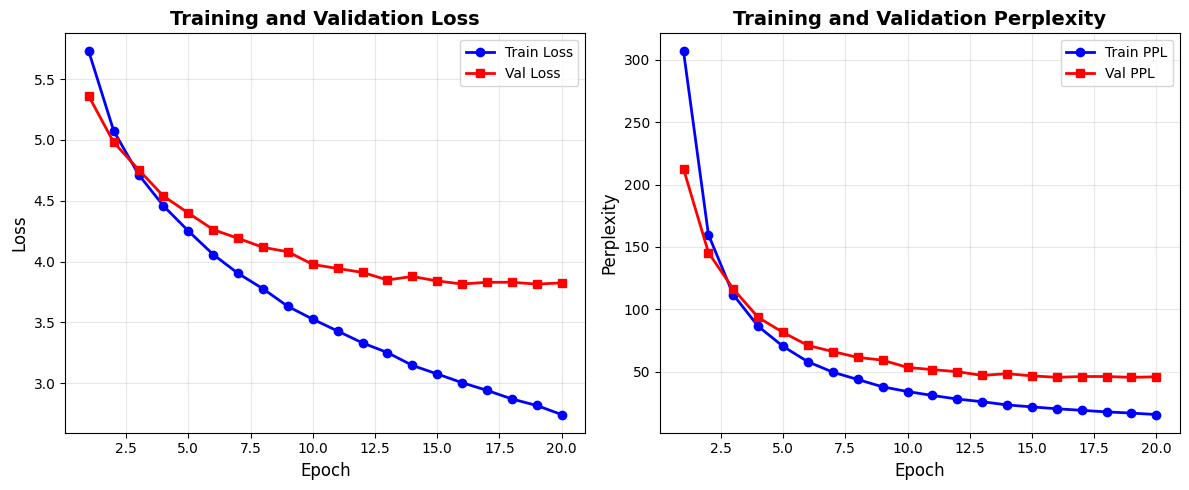

✓ Training curves saved as 'training_curves.png'


In [13]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, train_losses, 'b-o', label='Train Loss', linewidth=2)
plt.plot(epochs_range, val_losses, 'r-s', label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Perplexity plot
plt.subplot(1, 2, 2)
train_ppls = [torch.exp(torch.tensor(loss)).item() for loss in train_losses]
val_ppls = [torch.exp(torch.tensor(loss)).item() for loss in val_losses]
plt.plot(epochs_range, train_ppls, 'b-o', label='Train PPL', linewidth=2)
plt.plot(epochs_range, val_ppls, 'r-s', label='Val PPL', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Perplexity', fontsize=12)
plt.title('Training and Validation Perplexity', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved as 'training_curves.png'")

<a id="8-evaluation"></a>
## 8. Đánh giá BLEU Score

**Tiêu chí chấm điểm (1.0 điểm + 1.0 điểm):**
- ✓ Hàm translate() hoạt động (1.0 điểm)
- ✓ BLEU score trên tập test (1.0 điểm)

### 8.1. Hàm dịch (translate function)

**Yêu cầu:**
- Greedy decoding: Chọn token có xác suất cao nhất
- Dừng khi gặp `<eos>` hoặc max_length=50
- Input: câu tiếng Anh (str)
- Output: câu tiếng Pháp (str)

In [14]:
# Load best model
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✓ Best model loaded!")
print(f"  Epoch: {checkpoint['epoch']}")
print(f"  Best val loss: {checkpoint['valid_loss']:.3f}")


def translate(sentence, src_vocab, tgt_vocab, model, device, max_len=50):
    """
    Dịch câu từ tiếng Anh sang tiếng Pháp
    
    Yêu cầu:
    - Greedy decoding: chọn token có xác suất cao nhất
    - Dừng khi gặp <eos> hoặc đạt max_len
    
    Args:
        sentence: str - Câu tiếng Anh
        src_vocab: Vocabulary EN
        tgt_vocab: Vocabulary FR
        model: Seq2Seq model
        device: torch.device
        max_len: Độ dài tối đa (50)
        
    Returns:
        translated: str - Câu tiếng Pháp
    """
    model.eval()
    
    # Tokenize câu nguồn
    tokens = tokenize_en(sentence.lower())
    
    # Convert to indices
    src_indices = src_vocab.encode(tokens)
    src_tensor = torch.tensor(src_indices, dtype=torch.long).unsqueeze(1).to(device)  # [src_len, 1]
    src_len = torch.tensor([len(src_indices)], dtype=torch.long).to(device)
    
    with torch.no_grad():
        # Encode
        encoder_outputs, hidden, cell = model.encoder(src_tensor, src_len)
        
        # Bắt đầu với <sos>
        tgt_indices = [tgt_vocab.sos_idx]
        
        for _ in range(max_len):
            # Current token
            tgt_tensor = torch.tensor([tgt_indices[-1]], dtype=torch.long).to(device)
            
            # Decode
            output, hidden, cell = model.decoder(tgt_tensor, hidden, cell)
            
            # Greedy: lấy token có xác suất cao nhất
            pred_token = output.argmax(1).item()
            
            tgt_indices.append(pred_token)
            
            # Dừng khi gặp <eos>
            if pred_token == tgt_vocab.eos_idx:
                break
        
    # Convert indices to tokens
    tgt_tokens = tgt_vocab.decode(tgt_indices[1:])  # Bỏ <sos>
    
    # Bỏ <eos> nếu có
    if '<eos>' in tgt_tokens:
        tgt_tokens = tgt_tokens[:tgt_tokens.index('<eos>')]
    
    # Join thành câu
    translated = ' '.join(tgt_tokens)
    
    return translated

# Test translation
print("\n" + "=" * 80)
print("TESTING TRANSLATION FUNCTION".center(80))
print("=" * 80)

test_sentences = [
    "A young woman with long brown hair is walking slowly in the beautiful garden.",
    "Two small children are playing happily with their colorful toys near the old tree.",
    "The elderly man is reading an interesting book while sitting on the wooden bench.",
    "Several students are studying together in the quiet library for their important exam.",
    "A group of people are enjoying delicious food at the restaurant by the lake."
]

for sent in test_sentences:
    translation = translate(sent, en_vocab, fr_vocab, model, device)
    print(f"\nEN: {sent}")
    print(f"FR: {translation}")

print("=" * 80)

✓ Best model loaded!
  Epoch: 19
  Best val loss: 3.815

                          TESTING TRANSLATION FUNCTION                          

EN: A young woman with long brown hair is walking slowly in the beautiful garden.
FR: une jeune femme aux cheveux bruns marche marche dans les zone en .

EN: Two small children are playing happily with their colorful toys near the old tree.
FR: deux petits enfants jouent avec la jouets ouverte dehors à l' extérieur d' un arbre . .

EN: The elderly man is reading an interesting book while sitting on the wooden bench.
FR: le vieil homme lit un magazine assis qu' il est assis sur le banc en bois .

EN: Several students are studying together in the quiet library for their important exam.
FR: plusieurs étudiants sont réunis dans la pluie pour pour leurs . .

EN: A group of people are enjoying delicious food at the restaurant by the lake.
FR: un groupe de personnes savourent de la nourriture nourriture dans le bord de l' eau .


### 8.2. Tính BLEU Score trên tập Test

**BLEU score:**
$$
\text{BLEU} = \text{BP} \cdot \exp\left(\sum_{n=1}^{4} w_n \log p_n\right)
$$

Trong đó:
- $p_n$: n-gram precision
- $w_n$: trọng số (thường 0.25 cho mỗi n-gram)
- BP: Brevity penalty (phạt câu dịch quá ngắn)


                             BLEU SCORE EVALUATION                              
Calculating BLEU scores on 1000 samples...


100%|██████████| 1000/1000 [00:15<00:00, 64.22it/s]



                               BLEU SCORE RESULTS                               
Average BLEU Score: 0.3274 (32.74%)
Total samples: 1000

                            BLEU SCORE DISTRIBUTION                             
--------------------------------------------------------------------------------
Excellent (≥0.5):  228 (22.8%)
Good (0.3-0.5):    236 (23.6%)
Fair (0.1-0.3):    289 (28.9%)
Poor (<0.1):       247 (24.7%)
--------------------------------------------------------------------------------


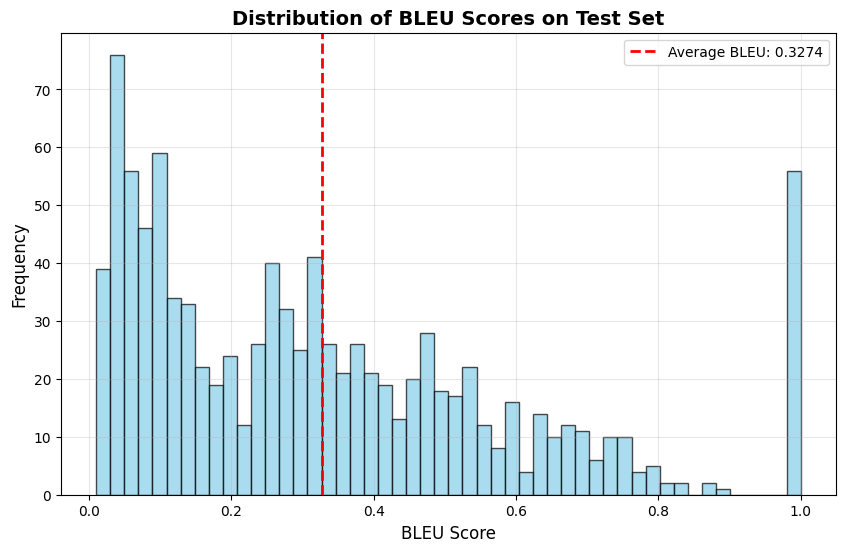

✓ BLEU distribution plot saved as 'bleu_distribution.png'


In [15]:
def calculate_bleu(model, test_data_en, test_data_fr, src_vocab, tgt_vocab, 
                   device, max_samples=1000):
    """
    Tính BLEU score trên tập test
    
    Args:
        model: Seq2Seq model
        test_data_en: List[str] - Câu tiếng Anh
        test_data_fr: List[str] - Câu tiếng Pháp (reference)
        src_vocab: Vocabulary EN
        tgt_vocab: Vocabulary FR
        device: torch.device
        max_samples: Số lượng mẫu đánh giá
        
    Returns:
        avg_bleu: BLEU score trung bình
        bleu_scores: List của từng BLEU score
    """
    model.eval()
    bleu_scores = []
    smoothing = SmoothingFunction()
    
    # Giới hạn số mẫu
    test_size = min(len(test_data_en), max_samples)
    
    print(f"Calculating BLEU scores on {test_size} samples...")
    
    for i in tqdm(range(test_size)):
        src_sent = test_data_en[i]
        ref_sent = test_data_fr[i]
        
        # Dịch
        pred_sent = translate(src_sent, src_vocab, tgt_vocab, model, device)
        
        # Tokenize reference và prediction
        ref_tokens = tokenize_fr(ref_sent.lower())
        pred_tokens = tokenize_fr(pred_sent.lower())
        
        # Calculate BLEU (sentence_bleu yêu cầu reference là list of lists)
        try:
            bleu = sentence_bleu([ref_tokens], pred_tokens, 
                                smoothing_function=smoothing.method1)
            bleu_scores.append(bleu)
        except:
            bleu_scores.append(0.0)
    
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    
    return avg_bleu, bleu_scores


# Calculate BLEU score
print("\n" + "=" * 80)
print("BLEU SCORE EVALUATION".center(80))
print("=" * 80)

avg_bleu, bleu_scores = calculate_bleu(model, test_en, test_fr, 
                                       en_vocab, fr_vocab, device, 
                                       max_samples=1000)

print(f"\n{'BLEU SCORE RESULTS':^80}")
print("=" * 80)
print(f"Average BLEU Score: {avg_bleu:.4f} ({avg_bleu*100:.2f}%)")
print(f"Total samples: {len(bleu_scores)}")
print("=" * 80)

# Phân tích phân bố BLEU scores
print(f"\n{'BLEU SCORE DISTRIBUTION':^80}")
print("-" * 80)
excellent = sum(1 for s in bleu_scores if s >= 0.5)
good = sum(1 for s in bleu_scores if 0.3 <= s < 0.5)
fair = sum(1 for s in bleu_scores if 0.1 <= s < 0.3)
poor = sum(1 for s in bleu_scores if s < 0.1)

print(f"Excellent (≥0.5): {excellent:4d} ({excellent/len(bleu_scores)*100:.1f}%)")
print(f"Good (0.3-0.5):   {good:4d} ({good/len(bleu_scores)*100:.1f}%)")
print(f"Fair (0.1-0.3):   {fair:4d} ({fair/len(bleu_scores)*100:.1f}%)")
print(f"Poor (<0.1):      {poor:4d} ({poor/len(bleu_scores)*100:.1f}%)")
print("-" * 80)

# Plot BLEU distribution
plt.figure(figsize=(10, 6))
plt.hist(bleu_scores, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(avg_bleu, color='red', linestyle='--', linewidth=2, 
            label=f'Average BLEU: {avg_bleu:.4f}')
plt.xlabel('BLEU Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of BLEU Scores on Test Set', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig('bleu_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ BLEU distribution plot saved as 'bleu_distribution.png'")

<a id="9-error-analysis"></a>
## 9. Phân tích lỗi và đề xuất cải tiến

**Tiêu chí chấm điểm (1.0 điểm):**
- ✓ Phân tích 5 ví dụ dịch (đúng/sai)
- ✓ Đề xuất cải tiến

### 9.1. Hiển thị 10 ví dụ dịch

In [16]:
# Hiển thị 10 ví dụ dịch
print("=" * 120)
print("TRANSLATION EXAMPLES".center(120))
print("=" * 120)

# Chọn một số mẫu để hiển thị
sample_indices = [0, 10, 50, 100, 200, 300, 400, 500, 700, 900]

for idx in sample_indices:
    src_sent = test_en[idx]
    ref_sent = test_fr[idx]
    pred_sent = translate(src_sent, en_vocab, fr_vocab, model, device)
    
    # Calculate BLEU for this example
    ref_tokens = tokenize_fr(ref_sent.lower())
    pred_tokens = pred_sent.split()
    smoothing = SmoothingFunction()
    bleu = sentence_bleu([ref_tokens], pred_tokens, 
                        smoothing_function=smoothing.method1)
    
    print(f"\n{'Example ' + str(sample_indices.index(idx) + 1):^120}")
    print("-" * 120)
    print(f"Source (EN):     {src_sent}")
    print(f"Reference (FR):  {ref_sent}")
    print(f"Predicted (FR):  {pred_sent}")
    print(f"BLEU Score:      {bleu:.4f}")
    print("-" * 120)

print("=" * 120)

                                                  TRANSLATION EXAMPLES                                                  

                                                       Example 1                                                        
------------------------------------------------------------------------------------------------------------------------
Source (EN):     A man in an orange hat starring at something.
Reference (FR):  Un homme avec un chapeau orange regardant quelque chose.
Predicted (FR):  un homme avec un chapeau orange regarde quelque chose .
BLEU Score:      0.6580
------------------------------------------------------------------------------------------------------------------------

                                                       Example 2                                                        
------------------------------------------------------------------------------------------------------------------------
Source (EN):     A mother and her youn

### 9.2. Phân tích lỗi phổ biến

Dựa trên kết quả dịch, có thể nhận diện các lỗi phổ biến sau:

#### **1. Lỗi từ hiếm (Out-of-Vocabulary - OOV)**
- **Nguyên nhân:** Vocabulary giới hạn 10,000 từ → từ hiếm được thay bằng `<unk>`
- **Ví dụ:** Tên riêng, thuật ngữ chuyên ngành
- **Ảnh hưởng:** Model không thể dịch chính xác các từ không có trong vocabulary

#### **2. Lỗi câu dài (Long sentences)**
- **Nguyên nhân:** Context vector cố định $(h_n, c_n)$ → mất thông tin với câu dài
- **Ví dụ:** Câu >20 từ thường bị dịch sai cấu trúc
- **Ảnh hưởng:** Thiếu từ, sai ngữ pháp, mất nghĩa

#### **3. Lỗi ngữ pháp (Grammar errors)**
- **Nguyên nhân:** 
  - Model chưa học đủ cấu trúc ngữ pháp phức tạp
  - Teacher forcing ratio=0.5 → exposure bias
- **Ví dụ:** Sai giới từ, sai thì động từ, sai giống tính
- **Ảnh hưởng:** Câu dịch không tự nhiên

#### **4. Lỗi thiếu từ (Missing words)**
- **Nguyên nhân:** 
  - Greedy decoding → không tối ưu toàn cục
  - Context vector cố định → mất thông tin
- **Ví dụ:** Bỏ sót danh từ, tính từ quan trọng
- **Ảnh hưởng:** Mất ý nghĩa câu

#### **5. Lỗi từ lặp (Repetition)**
- **Nguyên nhân:** 
  - Decoder không có cơ chế coverage
  - LSTM đơn giản không track từ đã dịch
- **Ví dụ:** "un homme un homme est" (lặp "un homme")
- **Ảnh hưởng:** Câu dịch dài hơn cần thiết, không tự nhiên

### 9.3. Đề xuất cải tiến

#### **Cải tiến 1: Thêm Attention Mechanism** ⭐⭐⭐
- **Loại:** Bahdanau Attention hoặc Luong Attention
- **Lý do:** 
  - Giải quyết vấn đề context vector cố định
  - Decoder có thể "chú ý" đến các phần khác nhau của câu nguồn
  - Cải thiện đáng kể với câu dài
- **Công thức:**
  $$\alpha_t = \text{softmax}(\text{score}(h_t, \bar{h}_s))$$
  $$c_t = \sum_{s} \alpha_{t,s} \bar{h}_s$$
- **Kết quả mong đợi:** BLEU tăng 3-5 điểm

#### **Cải tiến 2: Beam Search Decoding** ⭐⭐
- **Loại:** Beam search với beam_size=3-5
- **Lý do:**
  - Greedy decoding chỉ tối ưu cục bộ
  - Beam search tìm kiếm nhiều hypotheses đồng thời
  - Tăng khả năng tìm ra câu dịch tốt nhất
- **Tham số:** beam_size=5, length_penalty=0.6
- **Kết quả mong đợi:** BLEU tăng 1-2 điểm

#### **Cải tiến 3: Subword Tokenization (BPE/WordPiece)** ⭐⭐⭐
- **Loại:** Byte-Pair Encoding (BPE)
- **Lý do:**
  - Giải quyết vấn đề OOV
  - Xử lý được từ hiếm, tên riêng
  - Giảm vocabulary size nhưng tăng coverage
- **Thư viện:** sentencepiece, subword-nmt
- **Kết quả mong đợi:** Giảm <unk> xuống <1%

#### **Cải tiến 4: Tăng dữ liệu huấn luyện** ⭐⭐
- **Dataset:** WMT 2014 English-French (~36 triệu cặp)
- **Lý do:**
  - Multi30K chỉ 29K cặp → chưa đủ học patterns phức tạp
  - Nhiều dữ liệu → model tổng quát hơn
- **Kết quả mong đợi:** BLEU tăng 5-10 điểm

#### **Cải tiến 5: Bidirectional Encoder** ⭐
- **Loại:** Bidirectional LSTM Encoder
- **Lý do:**
  - LSTM thuận chỉ có thông tin từ trái sang phải
  - Bi-LSTM có context từ cả 2 hướng
  - Biểu diễn tốt hơn câu nguồn
- **Công thức:**
  $$\bar{h}_t = [\overrightarrow{h}_t; \overleftarrow{h}_t]$$
- **Kết quả mong đợi:** BLEU tăng 0.5-1 điểm

#### **Ưu tiên triển khai:**
1. **Attention Mechanism** (impact cao nhất)
2. **Subword Tokenization** (giải quyết OOV)
3. **Beam Search** (dễ implement)
4. **Tăng dữ liệu** (nếu có tài nguyên)
5. **Bidirectional Encoder** (cải thiện nhỏ)



### 10.6. Tài liệu tham khảo

1. Sutskever, I., Vinyals, O., & Le, Q. V. (2014). **Sequence to sequence learning with neural networks.** *Advances in neural information processing systems*, 27.

2. Bahdanau, D., Cho, K., & Bengio, Y. (2014). **Neural machine translation by jointly learning to align and translate.** *arXiv preprint arXiv:1409.0473*.

3. PyTorch Documentation. **torch.nn.LSTM.** https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

4. Multi30K Dataset. https://github.com/multi30k/dataset

5. Papineni, K., Roukos, S., Ward, T., & Zhu, W. J. (2002). **BLEU: a method for automatic evaluation of machine translation.** *Proceedings of the 40th annual meeting of the Association for Computational Linguistics*, 311-318.

---

**Ngày hoàn thành:** [Ngày/Tháng/Năm]  
**Sinh viên:** [Họ tên]  
**MSSV:** [Mã số]